# Spaceship Titanic

This is my second attempt at a Kaggle competition. Let us start by importing the necessary libraries: 


In [1]:
import pandas as pd
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from tensorflow.keras.layers import Normalization

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import EarlyStopping

2024-02-20 11:10:00.868621: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## I - Loading and exploring data

### a) Loading data

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_all = pd.concat([df_train, df_test], sort=False)
display(df_all.head())
display(df_all.dtypes)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported      object
dtype: object

### b) Visualizing  data

After loading the data, we will visualize the data to get a better understanding.

In [3]:
print(f"The DataFrame df_train has {df_all.shape[0]} rows and {df_all.shape[1]} columns.\n")

print("Descriptive statistics for the df_train DataFrame, rounded to two decimal places:") 
display(df_all.describe().round(1))

print("\nPercentage of missing values in each column of the df_train DataFrame:")
display(df_all.isnull().mean().mul(100).round(1).reset_index().rename(columns={0: 'Percentage', 'index': 'Column'}))

The DataFrame df_train has 12970 rows and 14 columns.

Descriptive statistics for the df_train DataFrame, rounded to two decimal places:


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,12700.0,12707.0,12681.0,12664.0,12686.0,12702.0
mean,28.8,222.9,452.0,174.9,308.5,306.8
std,14.4,647.6,1584.4,590.6,1130.3,1180.1
min,0.0,0.0,0.0,0.0,0.0,0.0
25%,19.0,0.0,0.0,0.0,0.0,0.0
50%,27.0,0.0,0.0,0.0,0.0,0.0
75%,38.0,49.0,77.0,29.0,57.0,42.0
max,79.0,14327.0,29813.0,23492.0,22408.0,24133.0



Percentage of missing values in each column of the df_train DataFrame:


,Column,Percentage
0,PassengerId,0.0
1,HomePlanet,2.2
2,CryoSleep,2.4
3,Cabin,2.3
4,Destination,2.1
5,Age,2.1
6,VIP,2.3
7,RoomService,2.0
8,FoodCourt,2.2
9,ShoppingMall,2.4


Visualizing non-numerical features:

In [4]:
df_all['PassengerId'] = df_all['PassengerId'].astype(str)
df_all[['Group_id', 'Id_in_Group']] = df_all['PassengerId'].str.split('_', expand=True)
print("Number of groups:", df_all['Group_id'].nunique())
display(df_all.head())

Number of groups: 9280


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group_id,Id_in_Group
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001,01
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002,01
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003,01
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,0003,02
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,0004,01


Plot repartition of HomePlanet, CryoSleep, Destination and VIP


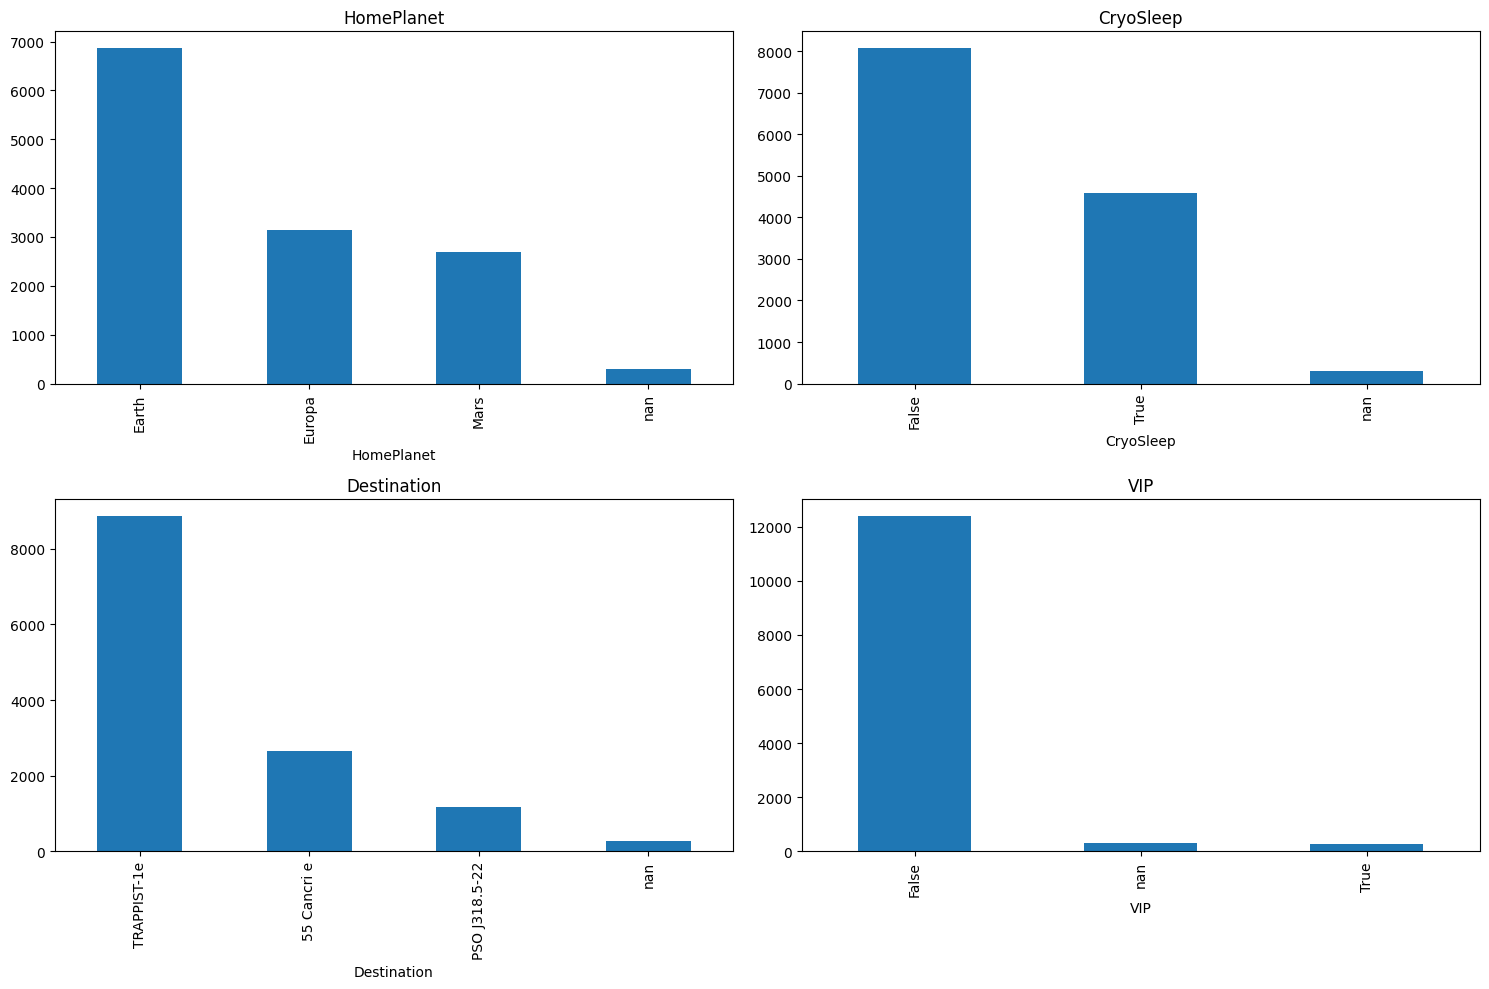

In [5]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
df_all['HomePlanet'].value_counts(dropna=False).plot.bar(title='HomePlanet', ax=ax[0][0])
df_all['CryoSleep'].value_counts(dropna=False).plot.bar(title='CryoSleep', ax=ax[0][1])
df_all['Destination'].value_counts(dropna=False).plot.bar(title='Destination', ax=ax[1][0])
df_all['VIP'].value_counts(dropna=False).plot.bar(title='VIP', ax=ax[1][1])
plt.tight_layout()
plt.show()

It interesting to visualize HomePlanet,CryoSleep,Destination, VIP distribution by transported:

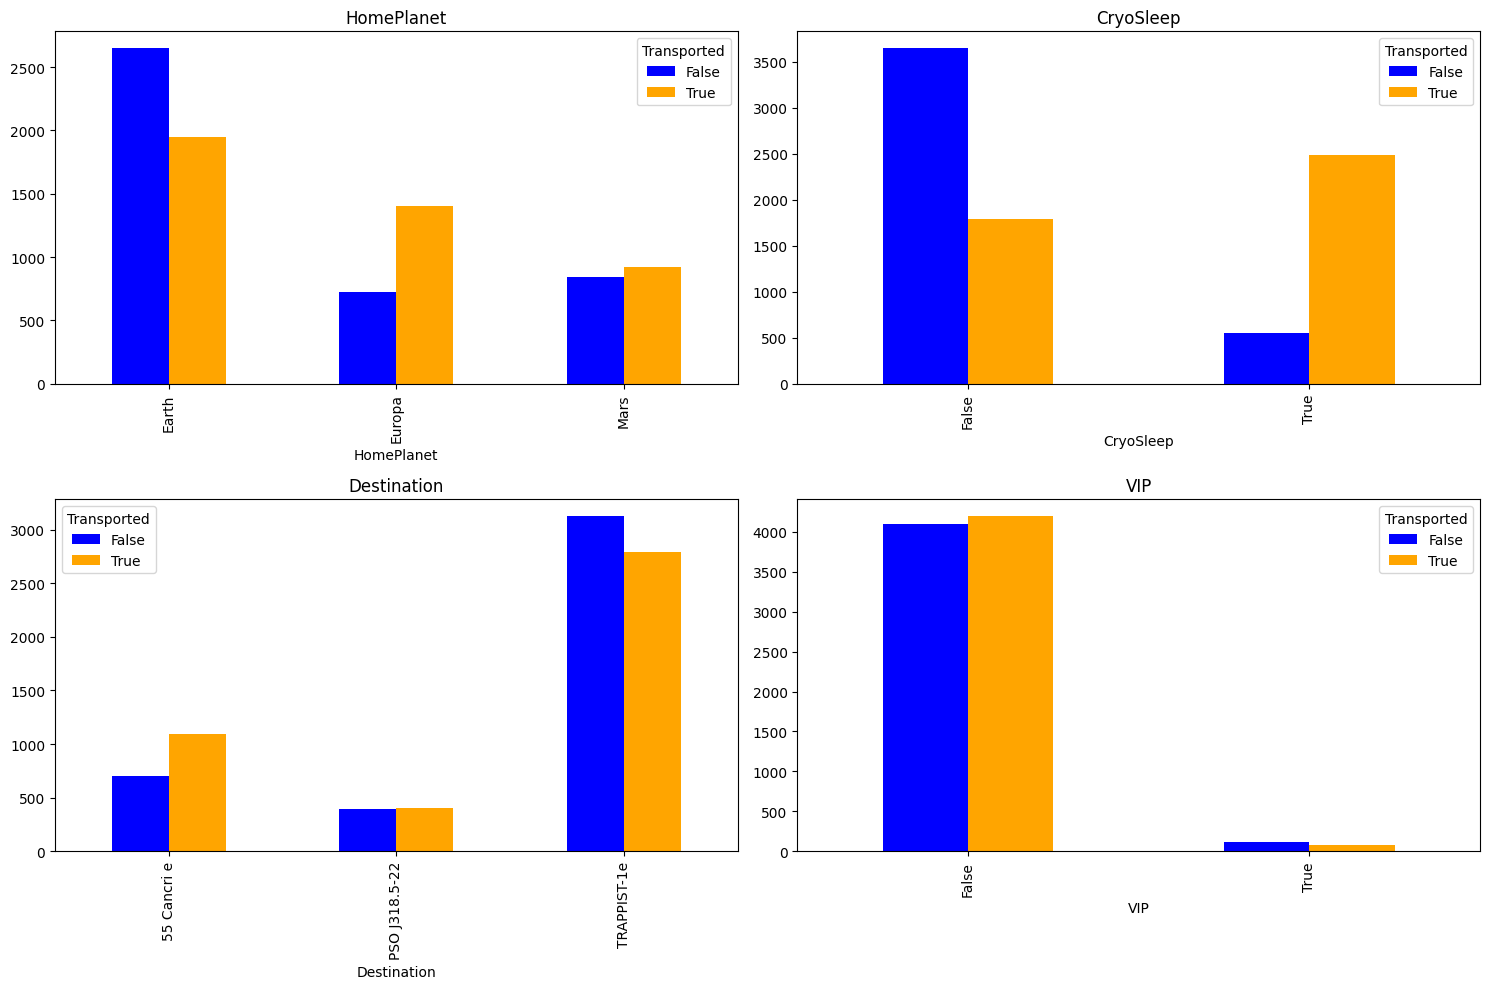

In [6]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
df_all.groupby(['HomePlanet', 'Transported']).size().unstack().plot.bar(title='HomePlanet', ax=ax[0][0], color=['blue', 'orange'])
df_all.groupby(['CryoSleep', 'Transported']).size().unstack().plot.bar(title='CryoSleep', ax=ax[0][1], color=['blue', 'orange'])
df_all.groupby(['Destination', 'Transported']).size().unstack().plot.bar(title='Destination', ax=ax[1][0], color=['blue', 'orange'])
df_all.groupby(['VIP', 'Transported']).size().unstack().plot.bar(title='VIP', ax=ax[1][1], color=['blue', 'orange'])

plt.tight_layout()
plt.show()


Splitting cabin into deck, number and side:

In [7]:
#splitting cabin into deck, number and side
df_all['Deck'] = df_all['Cabin'].str[0]
df_all['Number'] = df_all['Cabin'].str[2:-2]
df_all['Side'] = df_all['Cabin'].str[-1:]
df_all.drop('Cabin', axis=1, inplace=True)
display(df_all.head())

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group_id,Id_in_Group,Deck,Number,Side
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001,01,B,0,P
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002,01,F,0,S
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003,01,A,0,S
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,0003,02,A,0,S
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,0004,01,F,1,S


Visualizing Deck, Number and Side distribution by transported:

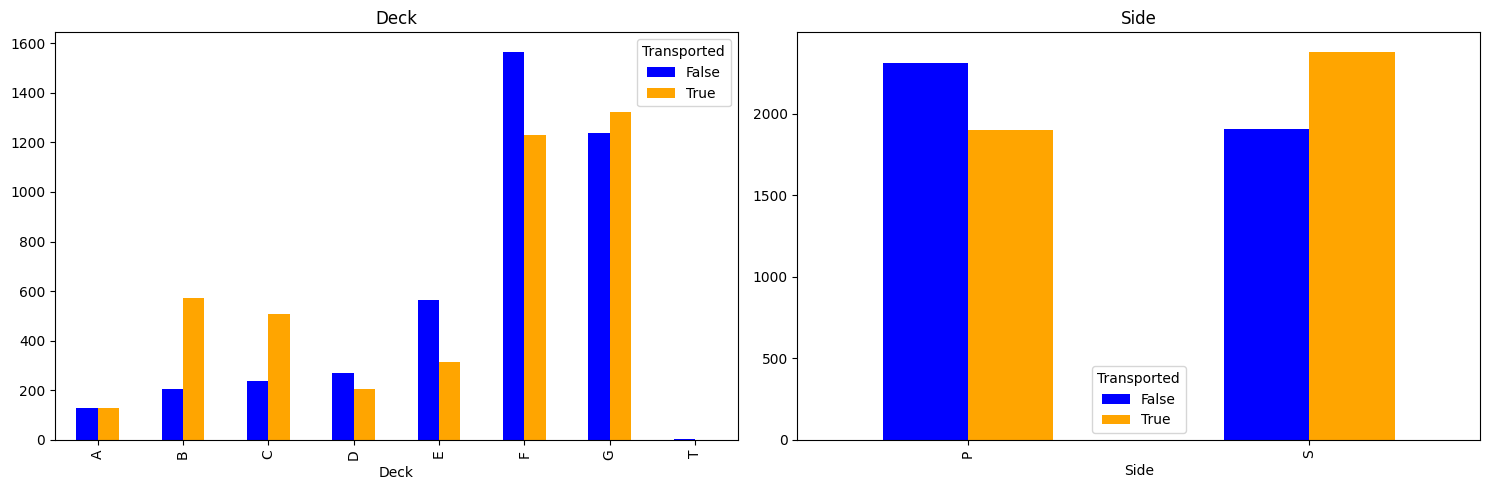

In [8]:
#Visualizing Deck and Side distribution by transported:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
df_all.groupby(['Deck', 'Transported']).size().unstack().plot.bar(title='Deck', ax=ax[0], color=['blue', 'orange'])
df_all.groupby(['Side', 'Transported']).size().unstack().plot.bar(title='Side', ax=ax[1], color=['blue', 'orange'])
plt.tight_layout()
plt.show()

Visualizing numerical features:

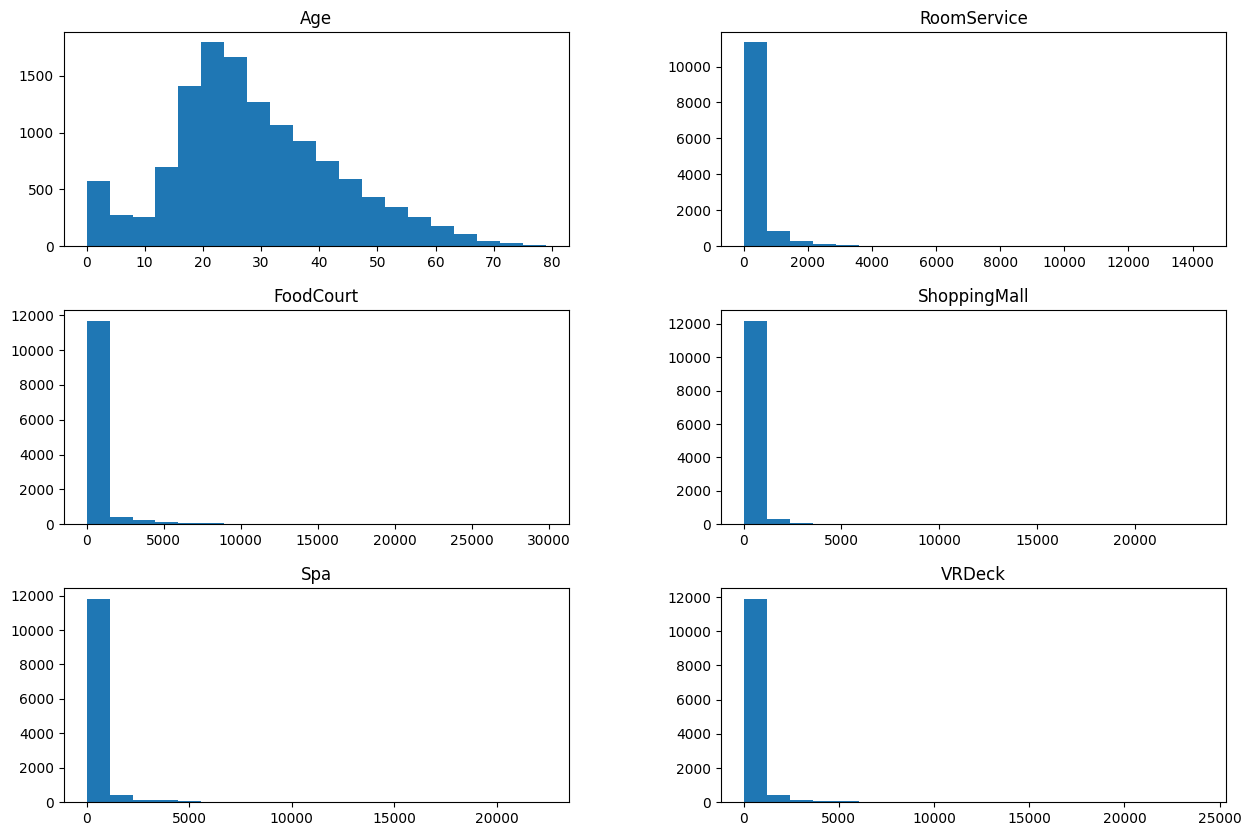

In [9]:
df_all.hist(figsize=(15, 10), bins=20, grid=False);

Convert HomePlanet, CryoSleep, Destination, VIP into numerical features:

In [10]:
df_all['HomePlanet'] = df_all['HomePlanet'].astype('category').cat.codes
df_all['CryoSleep'] = df_all['CryoSleep'].astype('category').cat.codes
df_all['Destination'] = df_all['Destination'].astype('category').cat.codes
df_all['VIP'] = df_all['VIP'].astype('category').cat.codes
df_all['Deck'] = df_all['Deck'].astype('category').cat.codes
df_all['Side'] = df_all['Side'].astype('category').cat.codes
display(df_all.head())

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group_id,Id_in_Group,Deck,Number,Side
0,0001_01,1,0,2,39.0,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001,01,1,0,0
1,0002_01,0,0,2,24.0,0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002,01,5,0,1
2,0003_01,1,0,2,58.0,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003,01,0,0,1
3,0003_02,1,0,2,33.0,0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,0003,02,0,0,1
4,0004_01,0,0,2,16.0,0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,0004,01,5,1,1


Convert Group_id, Id_in_Group, Transported and Number into numerical feature:

In [11]:
df_all['Group_id'] = df_all['Group_id'].astype(float)
df_all['Id_in_Group'] = df_all['Id_in_Group'].astype(float)
df_all['Transported'] = df_all['Transported'].astype(float) 
df_all['Number'] = df_all['Number'].astype(float)
display(df_all.dtypes)

PassengerId      object
HomePlanet         int8
CryoSleep          int8
Destination        int8
Age             float64
VIP                int8
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported     float64
Group_id        float64
Id_in_Group     float64
Deck               int8
Number          float64
Side               int8
dtype: object

### c) Replacing missing values

Checking if non VIP passengers have non 0 values for RoomService, FoodCourt, ShoppingMall, Spa, VRDeck:

In [12]:
display(df_all[(df_all['VIP'] == 0) & (df_all['RoomService'] != 0) | (df_all['FoodCourt'] != 0) | (df_all['ShoppingMall'] != 0) | (df_all['Spa'] != 0) | (df_all['VRDeck'] != 0)].shape[0])

display(df_all[(df_all['VIP'] == 0)].shape[0])

8105

12401

Code to see if individuals with missing values have more than one missing value

In [13]:
for i in range(1,8):
    print(i,df_all[df_all.isnull().sum(axis=1) >= i].shape[0])

1 5705
2 800
3 44
4 1
5 0
6 0
7 0


We will replace missing values with mean values or most frequent values and complete numerotation of group_id and id_in_group:

In [14]:
df_all['HomePlanet'].fillna(df_all['HomePlanet'].mode()[0], inplace=True)
df_all['CryoSleep'].fillna(df_all['CryoSleep'].mode()[0], inplace=True)
df_all['Destination'].fillna(df_all['Destination'].mode()[0], inplace=True)
df_all['Age'].fillna(df_all['Age'].mean(), inplace=True)
df_all['VIP'].fillna(df_all['VIP'].mode()[0], inplace=True)
df_all['RoomService'].fillna(df_all['RoomService'].mean(), inplace=True)
df_all['FoodCourt'].fillna(df_all['FoodCourt'].mean(), inplace=True)
df_all['ShoppingMall'].fillna(df_all['ShoppingMall'].mean(), inplace=True)
df_all['Spa'].fillna(df_all['Spa'].mean(), inplace=True)
df_all['VRDeck'].fillna(df_all['VRDeck'].mean(), inplace=True)
df_all['RoomService'].fillna(df_all['RoomService'].mean(), inplace=True)
df_all['Number'].fillna(df_all['Number'].mean(), inplace=True)
df_all.drop('Name', axis=1, inplace=True)

display(df_all.head())

print("\nPercentage of missing values in each column of the df_train DataFrame:")
display(df_all.isnull().mean().mul(100).round(1).reset_index().rename(columns={0: 'Percentage', 'index': 'Column'}))

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Group_id,Id_in_Group,Deck,Number,Side
0,0001_01,1,0,2,39.0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1,0.0,0
1,0002_01,0,0,2,24.0,0,109.0,9.0,25.0,549.0,44.0,1.0,2.0,1.0,5,0.0,1
2,0003_01,1,0,2,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0.0,3.0,1.0,0,0.0,1
3,0003_02,1,0,2,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0.0,3.0,2.0,0,0.0,1
4,0004_01,0,0,2,16.0,0,303.0,70.0,151.0,565.0,2.0,1.0,4.0,1.0,5,1.0,1



Percentage of missing values in each column of the df_train DataFrame:


,Column,Percentage
0,PassengerId,0.0
1,HomePlanet,0.0
2,CryoSleep,0.0
3,Destination,0.0
4,Age,0.0
5,VIP,0.0
6,RoomService,0.0
7,FoodCourt,0.0
8,ShoppingMall,0.0
9,Spa,0.0


Count number of members in each group

In [15]:
df_all['Group_size'] = df_all.groupby('Group_id')['Group_id'].transform('count')
display(df_all.head())

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Group_id,Id_in_Group,Deck,Number,Side,Group_size
0,0001_01,1,0,2,39.0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1,0.0,0,1
1,0002_01,0,0,2,24.0,0,109.0,9.0,25.0,549.0,44.0,1.0,2.0,1.0,5,0.0,1,1
2,0003_01,1,0,2,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0.0,3.0,1.0,0,0.0,1,2
3,0003_02,1,0,2,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0.0,3.0,2.0,0,0.0,1,2
4,0004_01,0,0,2,16.0,0,303.0,70.0,151.0,565.0,2.0,1.0,4.0,1.0,5,1.0,1,1


### d) Spliting data into train and test sets

In [16]:
df_all_pred = df_all.copy()

df_train = df_all_pred[df_all_pred['Transported'].notnull()]
X = df_train.drop(['Transported',"PassengerId"], axis=1)
y = df_train['Transported']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [17]:
df_test = df_all[df_all['Transported'].isnull()].copy()
df_id = df_test['PassengerId']
df_test.drop(['PassengerId','Transported'], axis=1, inplace=True)

display(df_test.head())

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Group_id,Id_in_Group,Deck,Number,Side,Group_size
0,0,1,2,27.0,0,0.0,0.0,0.0,0.0,0.0,13.0,1.0,6,3.0,1,1
1,0,0,2,19.0,0,0.0,9.0,0.0,2823.0,0.0,18.0,1.0,5,4.0,1,1
2,1,1,0,31.0,0,0.0,0.0,0.0,0.0,0.0,19.0,1.0,2,0.0,1,1
3,1,0,2,38.0,0,0.0,6652.0,0.0,181.0,585.0,21.0,1.0,2,1.0,1,1
4,0,0,2,20.0,0,10.0,0.0,635.0,0.0,0.0,23.0,1.0,5,5.0,1,1


## II - Model selection
### First model - Logistic Regression

In [18]:
model_lg = LogisticRegression(max_iter=10000)
parameters = {'C': [0.001,0.005,0.01]}

In [19]:
grid_search = GridSearchCV(estimator=model_lg, param_grid=parameters, cv=10)
grid_search.fit(X_train, y_train)
lg_pred = grid_search.best_estimator_

print("Best score: ", grid_search.best_score_)
print("Best parameters set:", grid_search.best_params_)

Best score:  0.7906257752418754
Best parameters set: {'C': 0.005}


In [20]:
print("RMSE on the test set: ", np.sqrt(mean_squared_error(y_test, lg_pred.predict(X_test))))
print("RMSE on the training set: ", np.sqrt(mean_squared_error(y_train, lg_pred.predict(X_train))))

RMSE on the test set:  0.4656084828957166
RMSE on the training set:  0.45836111244809935


In [21]:
y_pred_lg = lg_pred.predict(df_test)

### Second model - Random Forest

In [22]:
model_random_forest = RandomForestClassifier(random_state=2)

param_grid = {
    'n_estimators': [200,300,400],
    'max_depth': [1, 2, 3,5],
    'min_samples_leaf': [1, 2, 3,5]
}

In [23]:
grid_search = GridSearchCV(estimator=model_random_forest, param_grid=param_grid, cv=5, verbose=1)
grid_search.fit(X, y)
model_random_forest_pred = grid_search.best_estimator_

print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters: {'max_depth': 5, 'min_samples_leaf': 3, 'n_estimators': 300}
Best cross-validation score: 0.77


In [24]:
print("RMSE on the test set: ", np.sqrt(mean_squared_error(y_test, model_random_forest_pred.predict(X_test))))
print("RMSE on the training set: ", np.sqrt(mean_squared_error(y_train, model_random_forest_pred.predict(X_train))))

RMSE on the test set:  0.44411686861058747
RMSE on the training set:  0.4589881457268207


In [25]:
y_pred_rf = model_random_forest_pred.predict(df_test)

### Third model - LightGBM

In [26]:
gbm = lgb.LGBMClassifier(verbose=-1)

param_grid = {
    'learning_rate': [0.01, 0.1, 0.15, 0.25, 0.5],
    'num_leaves': [31, 50, 100],
    'max_bin': [255, 500, 1000, 1500]
}

In [27]:
grid_search = GridSearchCV(estimator=gbm, param_grid=param_grid, scoring='accuracy', verbose=0)
grid_search.fit(X, y)
gbm_pred = grid_search.best_estimator_

print("Best parameters", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

Best parameters {'learning_rate': 0.01, 'max_bin': 500, 'num_leaves': 31}
Best cross-validation score: 0.7652187579200777


In [28]:
print("RMSE on the test set: ", np.sqrt(mean_squared_error(y_test, gbm_pred.predict(X_test))))
print("RMSE on the training set: ", np.sqrt(mean_squared_error(y_train, gbm_pred.predict(X_train))))

RMSE on the test set:  0.4208482903568247
RMSE on the training set:  0.4340285567052736


In [29]:
y_pred_gbm = gbm_pred.predict(df_test)

### Fourth model - XGBoost

In [30]:
param_grid = {
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.01, 0.05],
    'n_estimators': [100, 200, 300, 400],
    'subsample': [0.8]
}

In [31]:
xgb_model = xgb.XGBClassifier()

grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X, y)
xgb_best_pred = grid_search.best_estimator_

print("Best parameters: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best parameters:  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Best cross-validation score:  0.7774112603899838


In [32]:
print("RMSE on the test set: ", np.sqrt(mean_squared_error(y_test, lg_pred.predict(X_test))))
print("RMSE on the training set: ", np.sqrt(mean_squared_error(y_train, lg_pred.predict(X_train))))

RMSE on the test set:  0.4656084828957166
RMSE on the training set:  0.45836111244809935


In [33]:
y_pred_xgb = xgb_best_pred.predict(df_test)

### Fifth model - CatBoost

In [34]:
param_grid = {
    'depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'n_estimators': [100, 200, 300, 400],
    'subsample': [0.8]
}

In [35]:
cat_model = CatBoostClassifier(verbose=0)

grid_search = GridSearchCV(cat_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X, y)
cat_best_pred = grid_search.best_estimator_

print("Best parameters: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)


Best parameters:  {'depth': 9, 'learning_rate': 0.01, 'n_estimators': 100, 'subsample': 0.8}
Best cross-validation score:  0.7878790966859913


In [36]:
print("RMSE on the test set: ", np.sqrt(mean_squared_error(y_test, cat_best_pred.predict(X_test))))
print("RMSE on the training set: ", np.sqrt(mean_squared_error(y_train, cat_best_pred.predict(X_train))))

RMSE on the test set:  0.4375949744936837
RMSE on the training set:  0.44740648470258654


In [37]:
y_pred_cat = cat_best_pred.predict(df_test)

### Sixth model - Neural Network

In [38]:
n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True)

accuracy_test_scores = []
accuracy_train_scores = []

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    normalizer = Normalization()
    normalizer.adapt(np.array(X_train_fold))
    
    model = keras.Sequential([
        normalizer,
        layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(0.001),
                  metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)

    model.fit(
        X_train_fold, y_train_fold,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=[early_stopping],
        verbose=0, epochs=500)

    accuracy_test = model.evaluate(X_test, y_test, verbose=0)[1]
    accuracy_train = model.evaluate(X_train_fold, y_train_fold, verbose=0)[1]
    
    accuracy_test_scores.append(accuracy_test)
    accuracy_train_scores.append(accuracy_train)

mean_accuracy_test = np.mean(accuracy_test_scores)
mean_accuracy_train = np.mean(accuracy_train_scores)


In [39]:
print("RMSE on the test set: ", np.sqrt(mean_squared_error(y_test, model.predict(X_test))))
print("RMSE on the training set: ", np.sqrt(mean_squared_error(y_train, model.predict(X_train))))

55/55 [==============================] - 0s 2ms/step
RMSE on the test set:  0.3575846648777821
218/218 [==============================] - 0s 837us/step
RMSE on the training set:  0.344784860740444


In [40]:
y_pred_nn = model.predict(df_test)
y_pred_nn = (y_pred_nn > 0.5).astype(float).flatten()

134/134 [==============================] - 0s 926us/step


# II - Resume of the results

Synthesis of the results of the different models:

| Modèle            | RMSE |
|-------------------|------------------|
| Logistic Regression | 0.466           |
| Random Forest       | 0.446           |
| LightGBM            | 0.421           |
| XGBoost             | 0.466           |
| CatBoost            | 0.421           |
| Neural Netork       | 0.424           |

Now, draw features importance for each model:

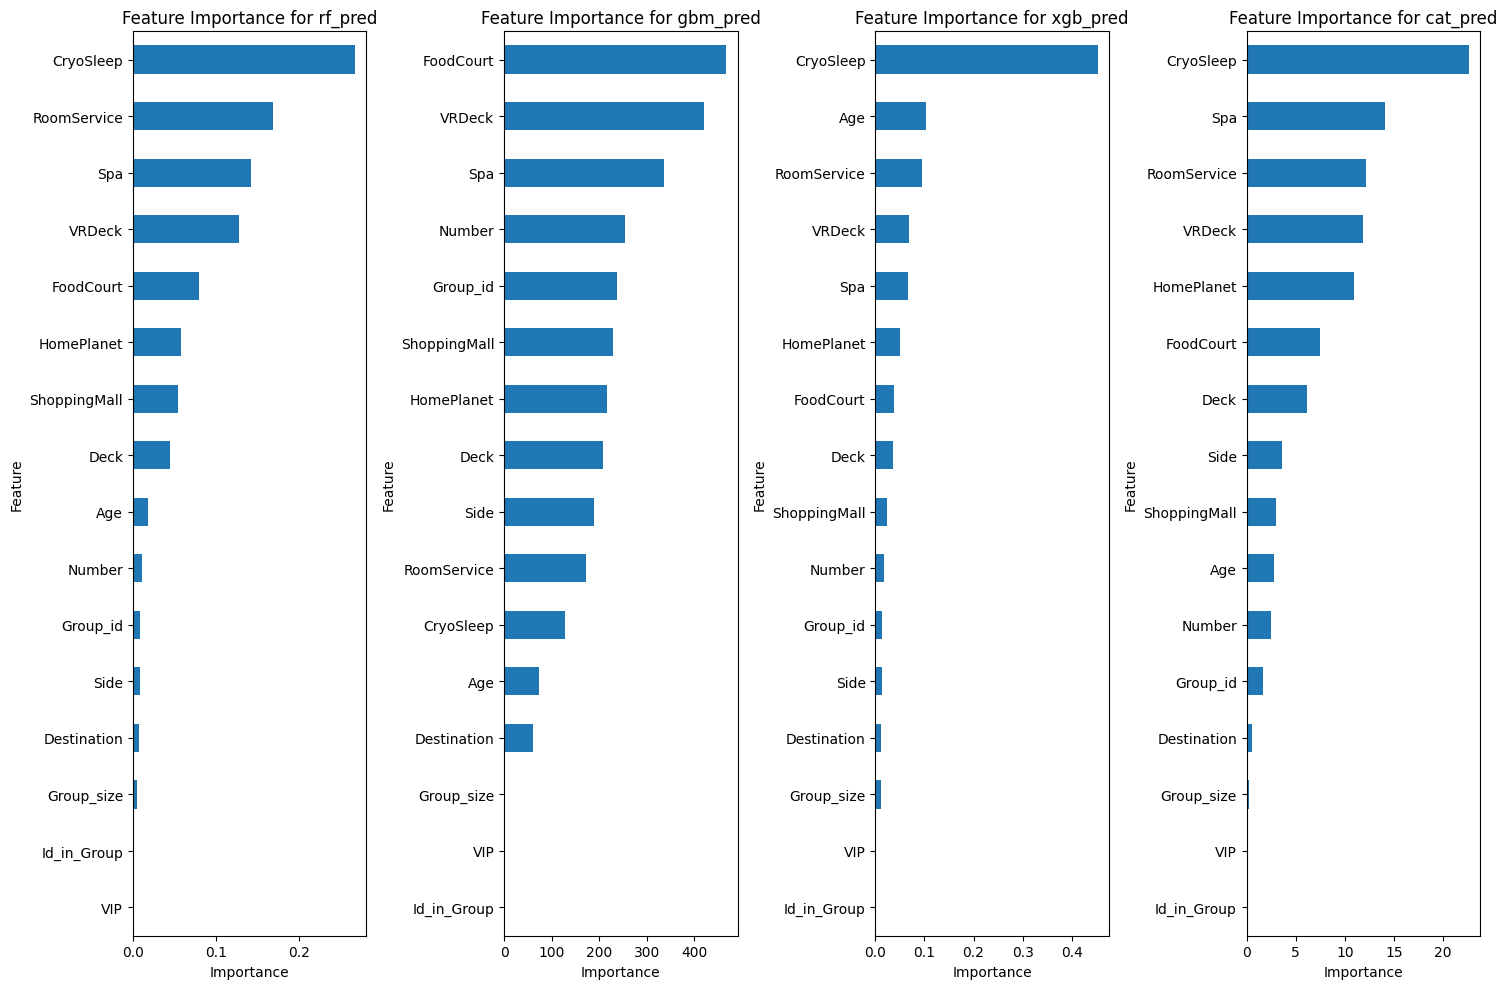

In [41]:
models = [
    {"name": "rf_pred", "model": model_random_forest_pred, "features": X.columns},
    {"name": "gbm_pred", "model": gbm_pred, "features": X.columns},
    {"name": "xgb_pred", "model": xgb_best_pred, "features": X.columns},
    {"name": "cat_pred", "model": cat_best_pred, "features": X.columns},
]

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(15, 10))

for i, mod in enumerate(models):
    feature_importance = pd.DataFrame({
        'feature': mod["features"],
        'importance': mod["model"].feature_importances_
    })

    feature_importance.sort_values(by='importance', ascending=False, inplace=True)
    feature_importance.reset_index(drop=True, inplace=True)

    ax = axs[i]
    feature_importance.head(20).plot(kind='barh', x='feature', y='importance', legend=False, ax=ax)
    ax.set_title(f'Feature Importance for {mod["name"]}')
    ax.set_xlabel('Importance')
    ax.set_ylabel('Feature')
    ax.invert_yaxis()

plt.tight_layout()
plt.show()

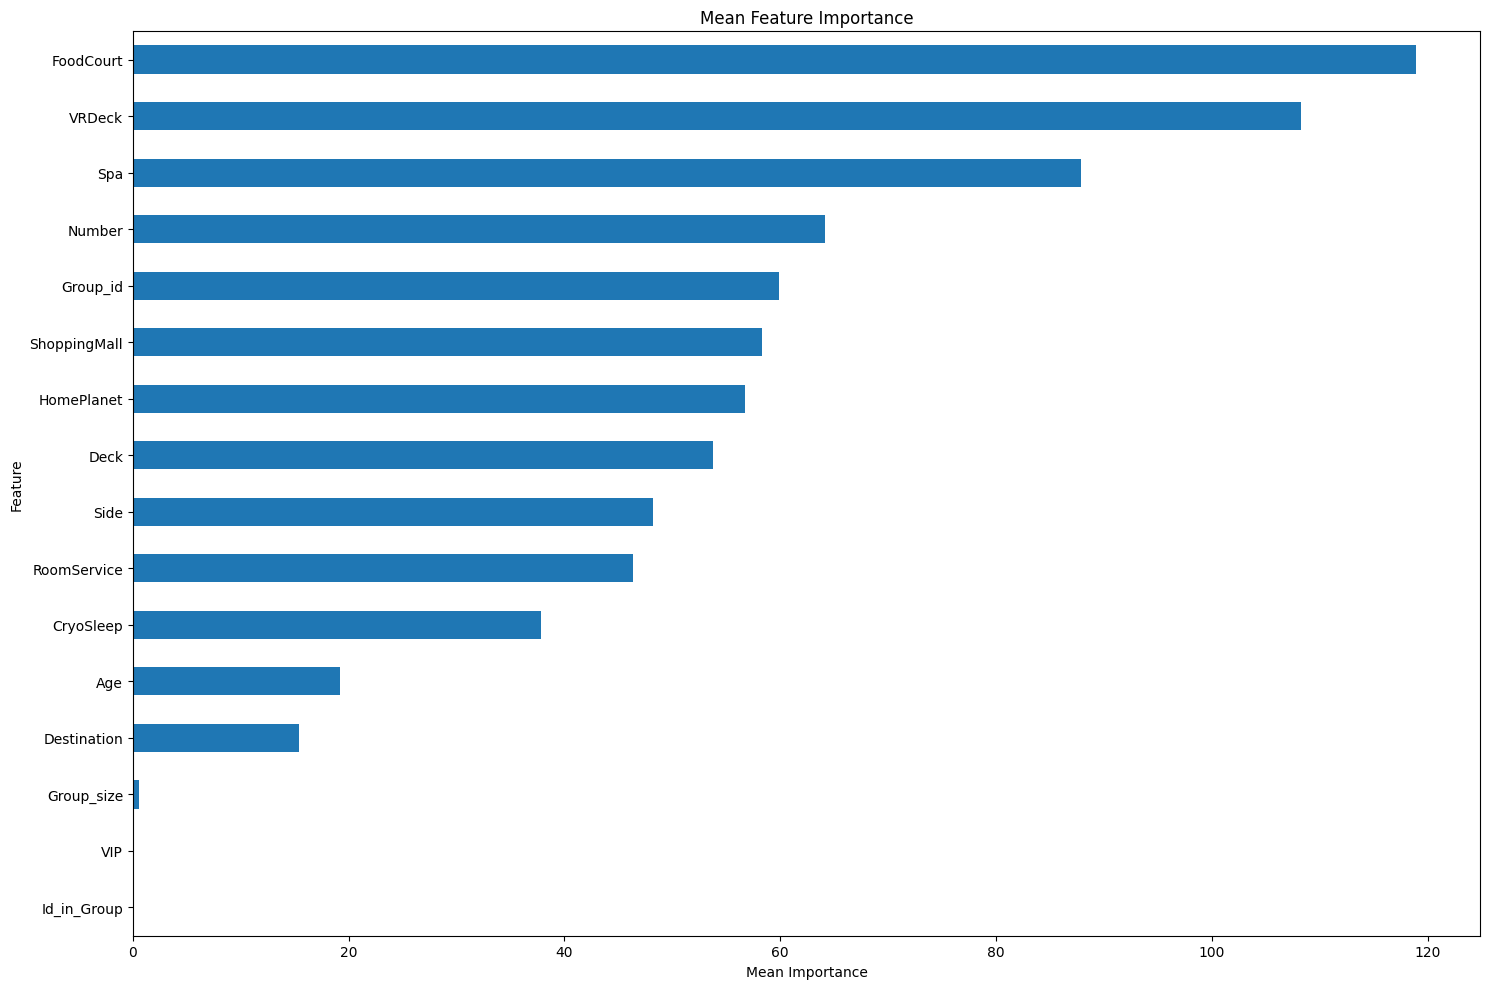

In [42]:
feature_importance = pd.DataFrame()

for mod in models:
    feature_importance[mod["name"]] = mod["model"].feature_importances_

feature_importance["feature"] = X.columns
feature_importance.set_index('feature', inplace=True)
feature_importance['mean'] = feature_importance.mean(axis=1)
feature_importance.sort_values(by='mean', ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(15, 10))
feature_importance['mean'].plot(kind='barh', ax=ax)
ax.set_title('Mean Feature Importance')
ax.set_xlabel('Mean Importance')
ax.set_ylabel('Feature')
ax.invert_yaxis()
plt.tight_layout()
plt.show()



# III - Evaluate on the test set

In [43]:
df_test

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Group_id,Id_in_Group,Deck,Number,Side,Group_size
0,0,1,2,27.000000,0,0.0,0.0,0.0,0.0,0.0,13.0,1.0,6,3.000000,1,1
1,0,0,2,19.000000,0,0.0,9.0,0.0,2823.0,0.0,18.0,1.0,5,4.000000,1,1
2,1,1,0,31.000000,0,0.0,0.0,0.0,0.0,0.0,19.0,1.0,2,0.000000,1,1
3,1,0,2,38.000000,0,0.0,6652.0,0.0,181.0,585.0,21.0,1.0,2,1.000000,1,1
4,0,0,2,20.000000,0,10.0,0.0,635.0,0.0,0.0,23.0,1.0,5,5.000000,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,0,1,2,34.000000,0,0.0,0.0,0.0,0.0,0.0,9266.0,2.0,6,1496.000000,1,2
4273,0,0,2,42.000000,0,0.0,847.0,17.0,10.0,144.0,9269.0,1.0,-1,603.601926,-1,1
4274,2,1,0,28.771969,0,0.0,0.0,0.0,0.0,0.0,9271.0,1.0,3,296.000000,0,1
4275,1,0,-1,28.771969,0,0.0,2680.0,0.0,0.0,523.0,9273.0,1.0,3,297.000000,0,1


In [44]:
predictions = [
    {"name": "lg_pred", "pred": y_pred_lg},
    {"name": "rf_pred", "pred": y_pred_rf},
    {"name": "gbm_pred", "pred": y_pred_gbm},
    {"name": "xgb_pred", "pred": y_pred_xgb},
    {"name": "cat_pred", "pred": y_pred_cat},
    {"name": "nn_pred", "pred": y_pred_nn},
]



for pred in predictions:
    pred["pred"] = [p > 0.5 for p in pred["pred"]]

    submission = pd.DataFrame({
        'PassengerId': df_id, 
        'Transported': pred["pred"]
    })

    submission.to_csv(f'gender_submission_{pred["name"]}.csv', index=False)


# IV - Results

| Modèle            | Accuracy on Kaggle |
|-------------------|------------------|
| Logistic Regression | 78.79           |
| Random Forest       | 78.77           |
| LightGBM            | 79.30           |
| XGBoost             | 78.72           |
| CatBoost            | 78.93           |
| Neural Netork       | 80.14           |